In [1]:
import pandas as pd
import torch
import sys
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split


sys.path.append("../../../")
from src.architectures.lstm.classifier import LSTMClassifier
from src.architectures.lstm.autoencoder import LSTMAutoEncoder
from src.dataset import ExerciseDataset
from src.trainer import Trainer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.manual_seed(0)

## Joints

### Data

In [3]:
squat_joints_df = pd.read_csv("../../../data/joints/squat.csv")
squat_joints_df.head()

,rep,frame,x,y,z,label
0,1,0,0.005017,0.068533,0.257256,correct
1,1,0,0.007799,0.000000,0.195177,correct
2,1,0,-0.052837,0.001294,0.195874,correct
3,1,0,-0.071019,-0.016791,0.096348,correct
4,1,0,-0.067215,-0.001036,0.000939,correct


In [4]:
squat_joints_dataset = ExerciseDataset(squat_joints_df, representation="joints")
dataset_length = len(squat_joints_dataset)

In [5]:
train_joints_squat_dataset, val_joints_squat_dataset = random_split(
    squat_joints_dataset,
    [int(0.95 * dataset_length), dataset_length - int(0.95 * dataset_length)],
    generator,
)

In [6]:
batch_size = 16

train_squat_joints_dl = DataLoader(
    train_joints_squat_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ExerciseDataset.pad_batch,
)

val_squat_joints_dl = DataLoader(
    val_joints_squat_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ExerciseDataset.pad_batch,
)

### Parameters 

In [7]:
NUM_JOINTS = 25
NUM_ANGLES = 6

LATENT_DIM = 64
SPACE_DIM = 3
NUM_CLASSES = 5
NUM_LAYERS = 4
HIDDEN_SIZE = 128

### Model

In [8]:
joints_lstm = LSTMClassifier(
    NUM_JOINTS * SPACE_DIM, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES
)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 0.0001
optimizer = torch.optim.Adam(joints_lstm.parameters(), lr)

### Training

In [9]:
trainer = Trainer(
    joints_lstm, train_squat_joints_dl, val_squat_joints_dl, loss_fn, optimizer, device
)
# results = trainer.train_classifier(num_epochs=250, weights_path="../models/joints_lstm_classifier.pt")

In [10]:
# plt.plot([result["train_loss"] for result in results], label="train acc")

Output values looks very uninteresting, that's probably because of how many features (75) were used as input and how many samples are in dataset (132).

## Angles

In [11]:
squat_angles_df = pd.read_csv("../../../data/angles/squat.csv")
squat_angles_df.head()

,rep,frame,left_knee,right_knee,right_arm,left_arm,left_hip,right_hip,label
0,1,0,167.455608,172.221420,156.794372,161.891089,175.869505,174.656520,correct
1,1,1,165.422781,170.596107,153.645161,160.043919,174.906872,175.458800,correct
2,1,2,162.825017,168.208123,149.462242,157.478636,172.839533,175.276172,correct
3,1,3,159.607962,165.029685,145.308846,154.201990,169.860558,173.482732,correct
4,1,4,155.860505,161.165659,141.762281,149.942374,166.194988,170.643770,correct


In [12]:
squat_angles_dataset = ExerciseDataset(squat_angles_df, representation="angles")

In [13]:
train_squat_angles_dataset, val_squat_angles_dataset = random_split(
    squat_angles_dataset,
    [int(0.95 * dataset_length), dataset_length - int(0.95 * dataset_length)],
    generator,
)

In [14]:
batch_size = 16

train_squat_angles_dl = DataLoader(
    train_squat_angles_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ExerciseDataset.pad_batch,
)

val_squat_angles_dl = DataLoader(
    val_squat_angles_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ExerciseDataset.pad_batch,
)

In [15]:
angles_lstm = LSTMClassifier(NUM_ANGLES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 0.0001
optimizer = torch.optim.Adam(angles_lstm.parameters(), lr)

In [16]:
trainer = Trainer(
    angles_lstm, train_squat_angles_dl, val_squat_angles_dl, loss_fn, optimizer, device
)
results = trainer.train_classifier(
    num_epochs=250, weights_path="../../../models/angles_lstm_classifier.pt"
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  5.22it/s]


2024-04-05 14:50:51,317: INFO     Epoch 1/250: Train Loss: 0.1031, Train Acc: 0.1760, Val Loss: 0.2305, Val Acc: 0.1429


100%|██████████| 8/8 [00:01<00:00,  4.44it/s]


2024-04-05 14:50:53,360: INFO     Epoch 2/250: Train Loss: 0.1030, Train Acc: 0.1760, Val Loss: 0.2300, Val Acc: 0.1429


100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


2024-04-05 14:50:55,205: INFO     Epoch 3/250: Train Loss: 0.1030, Train Acc: 0.1760, Val Loss: 0.2295, Val Acc: 0.1429


100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


2024-04-05 14:50:57,098: INFO     Epoch 4/250: Train Loss: 0.1029, Train Acc: 0.2960, Val Loss: 0.2289, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

2024-04-05 14:50:59,127: INFO     Epoch 5/250: Train Loss: 0.1028, Train Acc: 0.2960, Val Loss: 0.2281, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  5.04it/s]

2024-04-05 14:51:00,903: INFO     Epoch 6/250: Train Loss: 0.1026, Train Acc: 0.2960, Val Loss: 0.2269, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  4.59it/s]

2024-04-05 14:51:02,847: INFO     Epoch 7/250: Train Loss: 0.1024, Train Acc: 0.2960, Val Loss: 0.2247, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  4.42it/s]


2024-04-05 14:51:04,843: INFO     Epoch 8/250: Train Loss: 0.1020, Train Acc: 0.2960, Val Loss: 0.2215, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


2024-04-05 14:51:06,716: INFO     Epoch 9/250: Train Loss: 0.1016, Train Acc: 0.2960, Val Loss: 0.2154, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.33it/s]


2024-04-05 14:51:08,753: INFO     Epoch 10/250: Train Loss: 0.1010, Train Acc: 0.2960, Val Loss: 0.2080, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


2024-04-05 14:51:10,714: INFO     Epoch 11/250: Train Loss: 0.1011, Train Acc: 0.2960, Val Loss: 0.2097, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.42it/s]

2024-04-05 14:51:12,724: INFO     Epoch 12/250: Train Loss: 0.1012, Train Acc: 0.2960, Val Loss: 0.2130, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


2024-04-05 14:51:14,642: INFO     Epoch 13/250: Train Loss: 0.1008, Train Acc: 0.2960, Val Loss: 0.2102, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.31it/s]


2024-04-05 14:51:16,712: INFO     Epoch 14/250: Train Loss: 0.1004, Train Acc: 0.2960, Val Loss: 0.2050, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


2024-04-05 14:51:18,659: INFO     Epoch 15/250: Train Loss: 0.1001, Train Acc: 0.2960, Val Loss: 0.2041, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.44it/s]


2024-04-05 14:51:20,651: INFO     Epoch 16/250: Train Loss: 0.0996, Train Acc: 0.2960, Val Loss: 0.2005, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.45it/s]


2024-04-05 14:51:22,660: INFO     Epoch 17/250: Train Loss: 0.0989, Train Acc: 0.2960, Val Loss: 0.1937, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


2024-04-05 14:51:24,818: INFO     Epoch 18/250: Train Loss: 0.0984, Train Acc: 0.2960, Val Loss: 0.1894, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


2024-04-05 14:51:26,713: INFO     Epoch 19/250: Train Loss: 0.0978, Train Acc: 0.2960, Val Loss: 0.1888, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.76it/s]


2024-04-05 14:51:28,597: INFO     Epoch 20/250: Train Loss: 0.0970, Train Acc: 0.3120, Val Loss: 0.1897, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


2024-04-05 14:51:30,515: INFO     Epoch 21/250: Train Loss: 0.0957, Train Acc: 0.3680, Val Loss: 0.1877, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


2024-04-05 14:51:32,365: INFO     Epoch 22/250: Train Loss: 0.0943, Train Acc: 0.4160, Val Loss: 0.1838, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.70it/s]


2024-04-05 14:51:34,265: INFO     Epoch 23/250: Train Loss: 0.0943, Train Acc: 0.4080, Val Loss: 0.2015, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


2024-04-05 14:51:36,246: INFO     Epoch 24/250: Train Loss: 0.0937, Train Acc: 0.3920, Val Loss: 0.2019, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


2024-04-05 14:51:38,141: INFO     Epoch 25/250: Train Loss: 0.0936, Train Acc: 0.4320, Val Loss: 0.1950, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.36it/s]


2024-04-05 14:51:40,168: INFO     Epoch 26/250: Train Loss: 0.0931, Train Acc: 0.4800, Val Loss: 0.1976, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.94it/s]


2024-04-05 14:51:41,988: INFO     Epoch 27/250: Train Loss: 0.0916, Train Acc: 0.4720, Val Loss: 0.1805, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


2024-04-05 14:51:43,828: INFO     Epoch 28/250: Train Loss: 0.0914, Train Acc: 0.4560, Val Loss: 0.1902, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


2024-04-05 14:51:45,670: INFO     Epoch 29/250: Train Loss: 0.0928, Train Acc: 0.5200, Val Loss: 0.1957, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


2024-04-05 14:51:47,638: INFO     Epoch 30/250: Train Loss: 0.0904, Train Acc: 0.5520, Val Loss: 0.1824, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


2024-04-05 14:51:49,573: INFO     Epoch 31/250: Train Loss: 0.0930, Train Acc: 0.5120, Val Loss: 0.2031, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

2024-04-05 14:51:51,388: INFO     Epoch 32/250: Train Loss: 0.0923, Train Acc: 0.5120, Val Loss: 0.2010, Val Acc: 0.4286



100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


2024-04-05 14:51:53,264: INFO     Epoch 33/250: Train Loss: 0.0887, Train Acc: 0.5440, Val Loss: 0.1957, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  4.79it/s]


2024-04-05 14:51:55,148: INFO     Epoch 34/250: Train Loss: 0.0876, Train Acc: 0.5760, Val Loss: 0.2033, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  4.44it/s]


2024-04-05 14:51:57,156: INFO     Epoch 35/250: Train Loss: 0.0863, Train Acc: 0.5680, Val Loss: 0.1992, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


2024-04-05 14:51:59,145: INFO     Epoch 36/250: Train Loss: 0.0906, Train Acc: 0.4800, Val Loss: 0.1707, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


2024-04-05 14:52:01,095: INFO     Epoch 37/250: Train Loss: 0.0910, Train Acc: 0.4720, Val Loss: 0.1938, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


2024-04-05 14:52:03,005: INFO     Epoch 38/250: Train Loss: 0.0873, Train Acc: 0.5520, Val Loss: 0.2076, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


2024-04-05 14:52:04,984: INFO     Epoch 39/250: Train Loss: 0.0872, Train Acc: 0.5600, Val Loss: 0.2023, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

2024-04-05 14:52:06,713: INFO     Epoch 40/250: Train Loss: 0.0857, Train Acc: 0.5840, Val Loss: 0.2036, Val Acc: 0.4286



100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


2024-04-05 14:52:08,505: INFO     Epoch 41/250: Train Loss: 0.0939, Train Acc: 0.4400, Val Loss: 0.2246, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


2024-04-05 14:52:10,342: INFO     Epoch 42/250: Train Loss: 0.0888, Train Acc: 0.5280, Val Loss: 0.2194, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  4.46it/s]


2024-04-05 14:52:12,333: INFO     Epoch 43/250: Train Loss: 0.0876, Train Acc: 0.5280, Val Loss: 0.1987, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  5.08it/s]

2024-04-05 14:52:14,102: INFO     Epoch 44/250: Train Loss: 0.0866, Train Acc: 0.5360, Val Loss: 0.1962, Val Acc: 0.4286



100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


2024-04-05 14:52:16,007: INFO     Epoch 45/250: Train Loss: 0.0855, Train Acc: 0.5760, Val Loss: 0.2015, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


2024-04-05 14:52:17,794: INFO     Epoch 46/250: Train Loss: 0.0849, Train Acc: 0.5840, Val Loss: 0.2081, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


2024-04-05 14:52:19,413: INFO     Epoch 47/250: Train Loss: 0.0851, Train Acc: 0.5760, Val Loss: 0.2142, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

2024-04-05 14:52:21,134: INFO     Epoch 48/250: Train Loss: 0.0846, Train Acc: 0.5600, Val Loss: 0.1920, Val Acc: 0.4286



100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


2024-04-05 14:52:22,899: INFO     Epoch 49/250: Train Loss: 0.0857, Train Acc: 0.5680, Val Loss: 0.1729, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


2024-04-05 14:52:24,735: INFO     Epoch 50/250: Train Loss: 0.0854, Train Acc: 0.5680, Val Loss: 0.2225, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


2024-04-05 14:52:26,439: INFO     Epoch 51/250: Train Loss: 0.0840, Train Acc: 0.5920, Val Loss: 0.1993, Val Acc: 0.4286


100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

2024-04-05 14:52:28,091: INFO     Epoch 52/250: Train Loss: 0.0834, Train Acc: 0.6000, Val Loss: 0.1870, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

2024-04-05 14:52:29,819: INFO     Epoch 53/250: Train Loss: 0.0837, Train Acc: 0.6000, Val Loss: 0.1897, Val Acc: 0.4286



100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


2024-04-05 14:52:31,473: INFO     Epoch 54/250: Train Loss: 0.0820, Train Acc: 0.6160, Val Loss: 0.1691, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


2024-04-05 14:52:33,286: INFO     Epoch 55/250: Train Loss: 0.0815, Train Acc: 0.6560, Val Loss: 0.1787, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.96it/s]

2024-04-05 14:52:35,101: INFO     Epoch 56/250: Train Loss: 0.0811, Train Acc: 0.6480, Val Loss: 0.1736, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


2024-04-05 14:52:36,761: INFO     Epoch 57/250: Train Loss: 0.0806, Train Acc: 0.6320, Val Loss: 0.1653, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

2024-04-05 14:52:38,426: INFO     Epoch 58/250: Train Loss: 0.0811, Train Acc: 0.6720, Val Loss: 0.1870, Val Acc: 0.5714



100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


2024-04-05 14:52:40,057: INFO     Epoch 59/250: Train Loss: 0.0819, Train Acc: 0.6080, Val Loss: 0.1637, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


2024-04-05 14:52:41,693: INFO     Epoch 60/250: Train Loss: 0.0798, Train Acc: 0.6640, Val Loss: 0.1623, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.12it/s]


2024-04-05 14:52:43,453: INFO     Epoch 61/250: Train Loss: 0.0789, Train Acc: 0.7280, Val Loss: 0.1658, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


2024-04-05 14:52:45,159: INFO     Epoch 62/250: Train Loss: 0.0796, Train Acc: 0.6720, Val Loss: 0.1591, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.42it/s]


2024-04-05 14:52:47,168: INFO     Epoch 63/250: Train Loss: 0.0786, Train Acc: 0.7360, Val Loss: 0.1686, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


2024-04-05 14:52:48,967: INFO     Epoch 64/250: Train Loss: 0.0776, Train Acc: 0.7360, Val Loss: 0.1712, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


2024-04-05 14:52:50,796: INFO     Epoch 65/250: Train Loss: 0.0766, Train Acc: 0.7680, Val Loss: 0.1650, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


2024-04-05 14:52:52,554: INFO     Epoch 66/250: Train Loss: 0.0780, Train Acc: 0.7200, Val Loss: 0.1550, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.41it/s]


2024-04-05 14:52:53,995: INFO     Epoch 67/250: Train Loss: 0.0752, Train Acc: 0.8080, Val Loss: 0.1633, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


2024-04-05 14:52:55,441: INFO     Epoch 68/250: Train Loss: 0.0764, Train Acc: 0.8000, Val Loss: 0.1524, Val Acc: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


2024-04-05 14:52:56,922: INFO     Epoch 69/250: Train Loss: 0.0752, Train Acc: 0.7520, Val Loss: 0.1751, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


2024-04-05 14:52:58,388: INFO     Epoch 70/250: Train Loss: 0.0744, Train Acc: 0.8080, Val Loss: 0.1489, Val Acc: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


2024-04-05 14:52:59,889: INFO     Epoch 71/250: Train Loss: 0.0769, Train Acc: 0.7440, Val Loss: 0.1678, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


2024-04-05 14:53:01,368: INFO     Epoch 72/250: Train Loss: 0.0732, Train Acc: 0.8560, Val Loss: 0.1463, Val Acc: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


2024-04-05 14:53:02,832: INFO     Epoch 73/250: Train Loss: 0.0724, Train Acc: 0.8320, Val Loss: 0.1764, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.44it/s]


2024-04-05 14:53:04,270: INFO     Epoch 74/250: Train Loss: 0.0708, Train Acc: 0.8960, Val Loss: 0.1588, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.45it/s]


2024-04-05 14:53:05,704: INFO     Epoch 75/250: Train Loss: 0.0714, Train Acc: 0.8720, Val Loss: 0.1550, Val Acc: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


2024-04-05 14:53:07,206: INFO     Epoch 76/250: Train Loss: 0.0751, Train Acc: 0.7920, Val Loss: 0.1696, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  6.45it/s]


2024-04-05 14:53:08,642: INFO     Epoch 77/250: Train Loss: 0.0715, Train Acc: 0.8320, Val Loss: 0.1555, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.42it/s]


2024-04-05 14:53:10,080: INFO     Epoch 78/250: Train Loss: 0.0794, Train Acc: 0.6800, Val Loss: 0.1537, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.41it/s]


2024-04-05 14:53:11,526: INFO     Epoch 79/250: Train Loss: 0.0805, Train Acc: 0.6720, Val Loss: 0.1733, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


2024-04-05 14:53:13,059: INFO     Epoch 80/250: Train Loss: 0.0812, Train Acc: 0.6320, Val Loss: 0.1494, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


2024-04-05 14:53:14,603: INFO     Epoch 81/250: Train Loss: 0.0765, Train Acc: 0.7280, Val Loss: 0.1900, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


2024-04-05 14:53:16,139: INFO     Epoch 82/250: Train Loss: 0.0716, Train Acc: 0.8240, Val Loss: 0.1656, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


2024-04-05 14:53:17,628: INFO     Epoch 83/250: Train Loss: 0.0796, Train Acc: 0.6640, Val Loss: 0.1990, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


2024-04-05 14:53:19,128: INFO     Epoch 84/250: Train Loss: 0.0721, Train Acc: 0.8320, Val Loss: 0.1788, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


2024-04-05 14:53:20,688: INFO     Epoch 85/250: Train Loss: 0.0719, Train Acc: 0.8240, Val Loss: 0.1532, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.74it/s]


2024-04-05 14:53:22,069: INFO     Epoch 86/250: Train Loss: 0.0816, Train Acc: 0.6480, Val Loss: 0.2263, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  6.81it/s]


2024-04-05 14:53:23,438: INFO     Epoch 87/250: Train Loss: 0.0725, Train Acc: 0.8240, Val Loss: 0.1803, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


2024-04-05 14:53:24,917: INFO     Epoch 88/250: Train Loss: 0.0749, Train Acc: 0.7760, Val Loss: 0.1579, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

2024-04-05 14:53:26,414: INFO     Epoch 89/250: Train Loss: 0.0717, Train Acc: 0.8240, Val Loss: 0.1461, Val Acc: 0.8571



100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


2024-04-05 14:53:27,973: INFO     Epoch 90/250: Train Loss: 0.0738, Train Acc: 0.7920, Val Loss: 0.1824, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


2024-04-05 14:53:29,515: INFO     Epoch 91/250: Train Loss: 0.0704, Train Acc: 0.8240, Val Loss: 0.1679, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


2024-04-05 14:53:31,039: INFO     Epoch 92/250: Train Loss: 0.0674, Train Acc: 0.9040, Val Loss: 0.1621, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


2024-04-05 14:53:32,746: INFO     Epoch 93/250: Train Loss: 0.0665, Train Acc: 0.9120, Val Loss: 0.1723, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


2024-04-05 14:53:34,469: INFO     Epoch 94/250: Train Loss: 0.0695, Train Acc: 0.8240, Val Loss: 0.1467, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.20it/s]


2024-04-05 14:53:36,210: INFO     Epoch 95/250: Train Loss: 0.0675, Train Acc: 0.8720, Val Loss: 0.1514, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


2024-04-05 14:53:37,903: INFO     Epoch 96/250: Train Loss: 0.0672, Train Acc: 0.8880, Val Loss: 0.1678, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.14it/s]


2024-04-05 14:53:39,657: INFO     Epoch 97/250: Train Loss: 0.0662, Train Acc: 0.8960, Val Loss: 0.1704, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


2024-04-05 14:53:41,489: INFO     Epoch 98/250: Train Loss: 0.0665, Train Acc: 0.8960, Val Loss: 0.1495, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.79it/s]


2024-04-05 14:53:43,364: INFO     Epoch 99/250: Train Loss: 0.0696, Train Acc: 0.8400, Val Loss: 0.1544, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


2024-04-05 14:53:45,187: INFO     Epoch 100/250: Train Loss: 0.0673, Train Acc: 0.8880, Val Loss: 0.1726, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


2024-04-05 14:53:47,039: INFO     Epoch 101/250: Train Loss: 0.0697, Train Acc: 0.8320, Val Loss: 0.1684, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


2024-04-05 14:53:48,889: INFO     Epoch 102/250: Train Loss: 0.0721, Train Acc: 0.8000, Val Loss: 0.1555, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


2024-04-05 14:53:50,703: INFO     Epoch 103/250: Train Loss: 0.0681, Train Acc: 0.8640, Val Loss: 0.1598, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


2024-04-05 14:53:52,449: INFO     Epoch 104/250: Train Loss: 0.0674, Train Acc: 0.8880, Val Loss: 0.1632, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


2024-04-05 14:53:54,239: INFO     Epoch 105/250: Train Loss: 0.0686, Train Acc: 0.8640, Val Loss: 0.1768, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


2024-04-05 14:53:56,023: INFO     Epoch 106/250: Train Loss: 0.0692, Train Acc: 0.8320, Val Loss: 0.1708, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


2024-04-05 14:53:57,749: INFO     Epoch 107/250: Train Loss: 0.0682, Train Acc: 0.8480, Val Loss: 0.1681, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


2024-04-05 14:53:59,540: INFO     Epoch 108/250: Train Loss: 0.0652, Train Acc: 0.9120, Val Loss: 0.1718, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


2024-04-05 14:54:01,186: INFO     Epoch 109/250: Train Loss: 0.0716, Train Acc: 0.8080, Val Loss: 0.1751, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


2024-04-05 14:54:02,918: INFO     Epoch 110/250: Train Loss: 0.0749, Train Acc: 0.7440, Val Loss: 0.2199, Val Acc: 0.2857


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


2024-04-05 14:54:04,608: INFO     Epoch 111/250: Train Loss: 0.0677, Train Acc: 0.8640, Val Loss: 0.1518, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


2024-04-05 14:54:06,340: INFO     Epoch 112/250: Train Loss: 0.0746, Train Acc: 0.7520, Val Loss: 0.1618, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.01it/s]


2024-04-05 14:54:08,257: INFO     Epoch 113/250: Train Loss: 0.0698, Train Acc: 0.8240, Val Loss: 0.1322, Val Acc: 1.0000


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

2024-04-05 14:54:10,042: INFO     Epoch 114/250: Train Loss: 0.0684, Train Acc: 0.8560, Val Loss: 0.1701, Val Acc: 0.7143



100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


2024-04-05 14:54:11,787: INFO     Epoch 115/250: Train Loss: 0.0670, Train Acc: 0.8800, Val Loss: 0.1445, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


2024-04-05 14:54:13,616: INFO     Epoch 116/250: Train Loss: 0.0657, Train Acc: 0.8960, Val Loss: 0.1511, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.23it/s]


2024-04-05 14:54:15,731: INFO     Epoch 117/250: Train Loss: 0.0635, Train Acc: 0.9280, Val Loss: 0.1432, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


2024-04-05 14:54:17,637: INFO     Epoch 118/250: Train Loss: 0.0636, Train Acc: 0.9200, Val Loss: 0.1645, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

2024-04-05 14:54:19,559: INFO     Epoch 119/250: Train Loss: 0.0632, Train Acc: 0.9360, Val Loss: 0.1653, Val Acc: 0.7143



100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


2024-04-05 14:54:21,286: INFO     Epoch 120/250: Train Loss: 0.0634, Train Acc: 0.9280, Val Loss: 0.1503, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


2024-04-05 14:54:23,072: INFO     Epoch 121/250: Train Loss: 0.0643, Train Acc: 0.9200, Val Loss: 0.1420, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


2024-04-05 14:54:24,990: INFO     Epoch 122/250: Train Loss: 0.0628, Train Acc: 0.9440, Val Loss: 0.1634, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.96it/s]


2024-04-05 14:54:26,806: INFO     Epoch 123/250: Train Loss: 0.0657, Train Acc: 0.8960, Val Loss: 0.1709, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


2024-04-05 14:54:28,648: INFO     Epoch 124/250: Train Loss: 0.0639, Train Acc: 0.9200, Val Loss: 0.1617, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.10it/s]

2024-04-05 14:54:30,417: INFO     Epoch 125/250: Train Loss: 0.0628, Train Acc: 0.9440, Val Loss: 0.1513, Val Acc: 0.8571



100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


2024-04-05 14:54:32,256: INFO     Epoch 126/250: Train Loss: 0.0627, Train Acc: 0.9440, Val Loss: 0.1487, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.80it/s]


2024-04-05 14:54:34,165: INFO     Epoch 127/250: Train Loss: 0.0711, Train Acc: 0.8160, Val Loss: 0.1864, Val Acc: 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


2024-04-05 14:54:36,047: INFO     Epoch 128/250: Train Loss: 0.0664, Train Acc: 0.8800, Val Loss: 0.1570, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


2024-04-05 14:54:37,858: INFO     Epoch 129/250: Train Loss: 0.0660, Train Acc: 0.8800, Val Loss: 0.1535, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


2024-04-05 14:54:39,583: INFO     Epoch 130/250: Train Loss: 0.0643, Train Acc: 0.9120, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


2024-04-05 14:54:41,385: INFO     Epoch 131/250: Train Loss: 0.0671, Train Acc: 0.8640, Val Loss: 0.1719, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


2024-04-05 14:54:43,131: INFO     Epoch 132/250: Train Loss: 0.0633, Train Acc: 0.9280, Val Loss: 0.1658, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


2024-04-05 14:54:44,915: INFO     Epoch 133/250: Train Loss: 0.0631, Train Acc: 0.9280, Val Loss: 0.1610, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


2024-04-05 14:54:46,759: INFO     Epoch 134/250: Train Loss: 0.0619, Train Acc: 0.9520, Val Loss: 0.1701, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


2024-04-05 14:54:48,536: INFO     Epoch 135/250: Train Loss: 0.0615, Train Acc: 0.9600, Val Loss: 0.1706, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


2024-04-05 14:54:50,346: INFO     Epoch 136/250: Train Loss: 0.0624, Train Acc: 0.9360, Val Loss: 0.1525, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]

2024-04-05 14:54:52,286: INFO     Epoch 137/250: Train Loss: 0.0636, Train Acc: 0.9280, Val Loss: 0.1711, Val Acc: 0.7143



100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


2024-04-05 14:54:54,213: INFO     Epoch 138/250: Train Loss: 0.0611, Train Acc: 0.9600, Val Loss: 0.1641, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


2024-04-05 14:54:55,984: INFO     Epoch 139/250: Train Loss: 0.0614, Train Acc: 0.9520, Val Loss: 0.1656, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.18it/s]


2024-04-05 14:54:57,727: INFO     Epoch 140/250: Train Loss: 0.0628, Train Acc: 0.9440, Val Loss: 0.1694, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


2024-04-05 14:54:59,590: INFO     Epoch 141/250: Train Loss: 0.0609, Train Acc: 0.9680, Val Loss: 0.1619, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


2024-04-05 14:55:01,367: INFO     Epoch 142/250: Train Loss: 0.0616, Train Acc: 0.9520, Val Loss: 0.1627, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.13it/s]


2024-04-05 14:55:03,124: INFO     Epoch 143/250: Train Loss: 0.0617, Train Acc: 0.9520, Val Loss: 0.1512, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


2024-04-05 14:55:04,889: INFO     Epoch 144/250: Train Loss: 0.0610, Train Acc: 0.9680, Val Loss: 0.1519, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


2024-04-05 14:55:06,644: INFO     Epoch 145/250: Train Loss: 0.0608, Train Acc: 0.9680, Val Loss: 0.1459, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


2024-04-05 14:55:08,328: INFO     Epoch 146/250: Train Loss: 0.0607, Train Acc: 0.9680, Val Loss: 0.1674, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


2024-04-05 14:55:10,105: INFO     Epoch 147/250: Train Loss: 0.0605, Train Acc: 0.9680, Val Loss: 0.1696, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


2024-04-05 14:55:11,912: INFO     Epoch 148/250: Train Loss: 0.0605, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


2024-04-05 14:55:13,685: INFO     Epoch 149/250: Train Loss: 0.0605, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


2024-04-05 14:55:15,515: INFO     Epoch 150/250: Train Loss: 0.0606, Train Acc: 0.9680, Val Loss: 0.1700, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


2024-04-05 14:55:17,272: INFO     Epoch 151/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


2024-04-05 14:55:19,179: INFO     Epoch 152/250: Train Loss: 0.0605, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


2024-04-05 14:55:21,018: INFO     Epoch 153/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


2024-04-05 14:55:22,800: INFO     Epoch 154/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1701, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


2024-04-05 14:55:24,627: INFO     Epoch 155/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


2024-04-05 14:55:26,597: INFO     Epoch 156/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


2024-04-05 14:55:28,410: INFO     Epoch 157/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.02it/s]


2024-04-05 14:55:30,203: INFO     Epoch 158/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1701, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


2024-04-05 14:55:31,961: INFO     Epoch 159/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1701, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


2024-04-05 14:55:33,689: INFO     Epoch 160/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


2024-04-05 14:55:35,552: INFO     Epoch 161/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.13it/s]


2024-04-05 14:55:37,310: INFO     Epoch 162/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


2024-04-05 14:55:38,924: INFO     Epoch 163/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


2024-04-05 14:55:40,533: INFO     Epoch 164/250: Train Loss: 0.0605, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


2024-04-05 14:55:42,021: INFO     Epoch 165/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


2024-04-05 14:55:43,574: INFO     Epoch 166/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1701, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


2024-04-05 14:55:45,109: INFO     Epoch 167/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


2024-04-05 14:55:46,599: INFO     Epoch 168/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


2024-04-05 14:55:48,173: INFO     Epoch 169/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


2024-04-05 14:55:49,711: INFO     Epoch 170/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.40it/s]

2024-04-05 14:55:51,391: INFO     Epoch 171/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143



100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


2024-04-05 14:55:52,974: INFO     Epoch 172/250: Train Loss: 0.0613, Train Acc: 0.9520, Val Loss: 0.1703, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


2024-04-05 14:55:54,578: INFO     Epoch 173/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


2024-04-05 14:55:56,155: INFO     Epoch 174/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1698, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


2024-04-05 14:55:57,686: INFO     Epoch 175/250: Train Loss: 0.0603, Train Acc: 0.9680, Val Loss: 0.1700, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


2024-04-05 14:55:59,222: INFO     Epoch 176/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


2024-04-05 14:56:00,740: INFO     Epoch 177/250: Train Loss: 0.0616, Train Acc: 0.9520, Val Loss: 0.1703, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.46it/s]


2024-04-05 14:56:02,179: INFO     Epoch 178/250: Train Loss: 0.0606, Train Acc: 0.9600, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


2024-04-05 14:56:03,758: INFO     Epoch 179/250: Train Loss: 0.0614, Train Acc: 0.9520, Val Loss: 0.1704, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


2024-04-05 14:56:05,377: INFO     Epoch 180/250: Train Loss: 0.0610, Train Acc: 0.9520, Val Loss: 0.1705, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


2024-04-05 14:56:06,987: INFO     Epoch 181/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1664, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


2024-04-05 14:56:08,494: INFO     Epoch 182/250: Train Loss: 0.0604, Train Acc: 0.9680, Val Loss: 0.1699, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.39it/s]


2024-04-05 14:56:09,939: INFO     Epoch 183/250: Train Loss: 0.0608, Train Acc: 0.9600, Val Loss: 0.1699, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


2024-04-05 14:56:11,534: INFO     Epoch 184/250: Train Loss: 0.0609, Train Acc: 0.9680, Val Loss: 0.1534, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


2024-04-05 14:56:13,091: INFO     Epoch 185/250: Train Loss: 0.0602, Train Acc: 0.9680, Val Loss: 0.1700, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


2024-04-05 14:56:14,696: INFO     Epoch 186/250: Train Loss: 0.0611, Train Acc: 0.9520, Val Loss: 0.1692, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


2024-04-05 14:56:16,161: INFO     Epoch 187/250: Train Loss: 0.0611, Train Acc: 0.9520, Val Loss: 0.1700, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


2024-04-05 14:56:17,685: INFO     Epoch 188/250: Train Loss: 0.0606, Train Acc: 0.9600, Val Loss: 0.1696, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


2024-04-05 14:56:19,147: INFO     Epoch 189/250: Train Loss: 0.0608, Train Acc: 0.9520, Val Loss: 0.1702, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.05it/s]

2024-04-05 14:56:20,670: INFO     Epoch 190/250: Train Loss: 0.0630, Train Acc: 0.9200, Val Loss: 0.1700, Val Acc: 0.7143



100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


2024-04-05 14:56:22,290: INFO     Epoch 191/250: Train Loss: 0.0665, Train Acc: 0.8720, Val Loss: 0.1700, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


2024-04-05 14:56:23,852: INFO     Epoch 192/250: Train Loss: 0.0644, Train Acc: 0.9040, Val Loss: 0.1693, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.32it/s]


2024-04-05 14:56:25,554: INFO     Epoch 193/250: Train Loss: 0.0639, Train Acc: 0.9120, Val Loss: 0.1693, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


2024-04-05 14:56:27,147: INFO     Epoch 194/250: Train Loss: 0.0649, Train Acc: 0.8960, Val Loss: 0.1693, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


2024-04-05 14:56:28,703: INFO     Epoch 195/250: Train Loss: 0.0662, Train Acc: 0.8800, Val Loss: 0.1597, Val Acc: 0.8571


100%|██████████| 8/8 [00:01<00:00,  6.39it/s]


2024-04-05 14:56:30,150: INFO     Epoch 196/250: Train Loss: 0.0643, Train Acc: 0.9040, Val Loss: 0.1699, Val Acc: 0.7143


100%|██████████| 8/8 [00:01<00:00,  6.34it/s]

2024-04-05 14:56:31,609: INFO     Epoch 197/250: Train Loss: 0.0664, Train Acc: 0.8560, Val Loss: 0.1702, Val Acc: 0.7143
2024-04-05 14:56:31,609: WARNING  Eary stopping the training!


2024-04-05 14:56:31,618: INFO     Best model saved in ../../../models/angles_lstm_classifier.pt


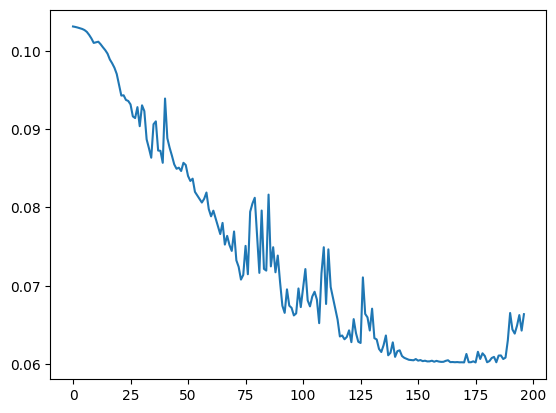

In [18]:
plt.plot([result["train_loss"] for result in results], label="train loss")